<a href="https://colab.research.google.com/github/Saku052/GlobalOSMarketShare/blob/main/GlobalOSMarketShare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import scipy.stats as st

In [25]:
#グローバルマーケットシェアのデータをインポート
Orig_df = pd.read_csv("/content/gloabal_marketshare.csv")
Orig_df.tail(3)

,Date,WinTotal,Win7,Win10,Win 8.1,Win 8,WinXP,WinVista,Windows,MacOSX,iOS,Android,Tablet,Linux,Chrome OS,Other
114,Jul '21,68.38,NaN,NaN,NaN,NaN,NaN,NaN,68.38,14.44,3.42,2.77,6.19,2.23,1.13,7.63
115,Aug '21,71.13,NaN,NaN,NaN,NaN,NaN,NaN,71.13,15.08,3.52,2.85,6.37,2.23,1.62,3.57
116,Sep '21,71.06,NaN,NaN,NaN,NaN,NaN,NaN,71.06,15.01,3.02,2.51,5.53,2.20,2.44,3.76


In [26]:
#必要データだけをまとめる
Dropped_df = pd.DataFrame(
    data = {"MacOS" : Orig_df["MacOSX"].dropna(),
            "WINDOWS" : Orig_df["Windows"].dropna()}
)
df = Dropped_df.dropna()
df.tail(5)

,MacOS,WINDOWS
112,14.87,68.94
113,14.16,68.54
114,14.44,68.38
115,15.08,71.13
116,15.01,71.06


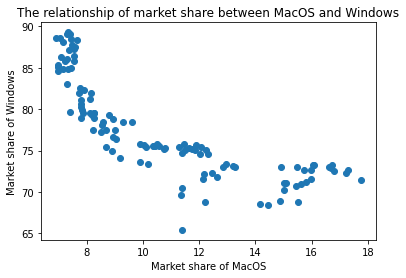

In [27]:
#離散図の描写
plt.scatter(df["MacOS"], df["WINDOWS"])
plt.xlabel("Market share of MacOS")
plt.ylabel("Market share of Windows")
plt.title("The relationship of market share between MacOS and Windows")
plt.show()

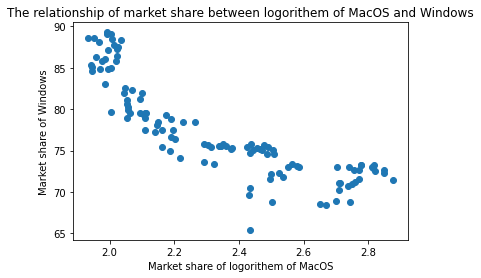

In [28]:
#MacOSのLOGをとった新たな変数の作成
df["LogMac"] = np.log(df["MacOS"])

#離散図の描写
plt.scatter(df["LogMac"], df["WINDOWS"])
plt.xlabel("Market share of logorithem of MacOS")
plt.ylabel("Market share of Windows")
plt.title("The relationship of market share between logorithem of MacOS and Windows")
plt.show()

In [29]:
#モデルの生成
model = sm.ols("WINDOWS~LogMac", df).fit()
print(model.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.727   
Dependent Variable: WINDOWS          AIC:                593.9172
Date:               2022-11-24 12:08 BIC:                599.4416
No. Observations:   117              Log-Likelihood:     -294.96 
Df Model:           1                F-statistic:        309.8   
Df Residuals:       115              Prob (F-statistic): 2.03e-34
R-squared:          0.729            Scale:              9.2202  
-----------------------------------------------------------------
               Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
-----------------------------------------------------------------
Intercept     117.5535   2.2947  51.2291 0.0000 113.0082 122.0988
LogMac        -17.2562   0.9804 -17.6007 0.0000 -19.1982 -15.3141
-----------------------------------------------------------------
Omnibus:               0.266        Durbin-Watson:          0.252
Prob(Omnibus):         0.87

回帰の有意性を確かめる為の帰無仮説を立てる



*   H_0 : beta = 0
*   H_A : beta != 0





t statistics = 51.2291

p value = 0.000

p value < 0.05 により、帰無仮説は棄却され対立仮説が採択される。
よって、この回帰は有意性をもつ。

ここで、R^2 = 0.727 である事から、モデルの信頼度がそこまで高くない事が分かる。

よって先ずは、クックの距離から外れ値の除去を行う

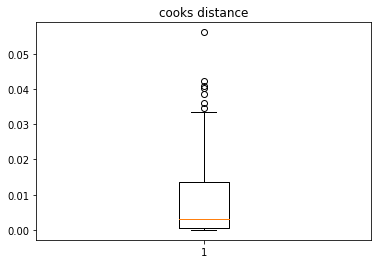

In [30]:
#クックの距離から外れ値を測定する
df_infl = model.get_influence().summary_frame()
plt.boxplot(df_infl["cooks_d"])
plt.title("cooks distance")
plt.show()

In [31]:
#クックの距離0.03を超えているデータをドロップ
def getindexOutliear(cooksd):
  outlier = cooksd[(cooksd > 0.03)]
  return outlier.index

filtered_df = df.drop(getindexOutliear(df_infl["cooks_d"]))
filtered_df.reset_index(inplace=True)
filtered_df.tail(3)

,index,MacOS,WINDOWS,LogMac
104,114,14.44,68.38,2.670002
105,115,15.08,71.13,2.713369
106,116,15.01,71.06,2.708717


In [32]:
#新規モデルの生成
model2 = sm.ols("WINDOWS~LogMac", filtered_df).fit()
print(model2.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.764   
Dependent Variable: WINDOWS          AIC:                509.2752
Date:               2022-11-24 12:08 BIC:                514.6209
No. Observations:   107              Log-Likelihood:     -252.64 
Df Model:           1                F-statistic:        343.7   
Df Residuals:       105              Prob (F-statistic): 6.82e-35
R-squared:          0.766            Scale:              6.7073  
-----------------------------------------------------------------
               Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
-----------------------------------------------------------------
Intercept     116.6425   2.1403  54.4986 0.0000 112.3987 120.8863
LogMac        -17.0061   0.9174 -18.5381 0.0000 -18.8251 -15.1872
-----------------------------------------------------------------
Omnibus:              1.734        Durbin-Watson:           0.255
Prob(Omnibus):        0.420

外れ値を除去したことによってR^2は0.037上昇し、0.764になった。

この事から回帰モデルの正確性の面では不安が残るという事が言える。結果から見れば、このモデルには深刻なデータ不足が根本的な問題点であることが分かり、更なるデータの取得が求められる。

次に、データの残差の正規性と偏差についての検証をしていく。

上記の回帰はOLSによって導かれているが、これは仮のものであり、偏差や正規性が保たれていなければ、WLS,GLSを使用しなければならない。

In [33]:
#Windows_hatの生成と、残差の計算
filtered_df["Win_pred"] = model2.predict(filtered_df)
filtered_df["Residuals"] = filtered_df["Win_pred"] - filtered_df["WINDOWS"]
filtered_df.tail(3)

,index,MacOS,WINDOWS,LogMac,Win_pred,Residuals
104,114,14.44,68.38,2.670002,71.236107,2.856107
105,115,15.08,71.13,2.713369,70.498598,-0.631402
106,116,15.01,71.06,2.708717,70.577723,-0.482277


先ず、残差の正規性を検証する為にシャピロ-ウィルク検定を行る



> シャピロ-ウィルク検定

帰無仮説 H_0 : データが正規分布に従う

対立仮説 H_A : データが正規分布に従わない

有意水準0.05でこの検定を行う


In [40]:
st.shapiro(filtered_df["Residuals"])

ShapiroResult(statistic=0.9793999195098877, pvalue=0.09533452242612839)

結果

t statistic = 0.98

p value = 0.09

p value > 0.05 よって帰無仮説が受容され、残差の正規性に関してはこれだけだと結論付けられない。

次に正規性の検証の為、ヒストグラムとQQプロットを使用する。

In [35]:
#正規分布の生成と、残差の正規性
filtered_df["Residuals"] = st.zscore(filtered_df["Residuals"])

def CreateNDist(data):
  n_norm = np.linspace(data.min(), data.max(), 1000)
  p_norm = []
  for i in range(len(n_norm)):
    p_norm.append(st.norm.pdf(x = n_norm[i], loc = 0, scale = 1))
  return n_norm, p_norm

n, p = CreateNDist(filtered_df["Residuals"])

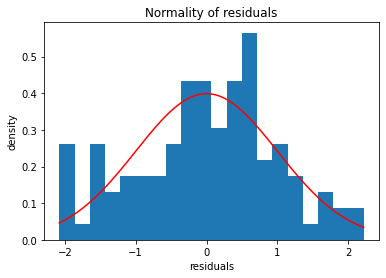

In [36]:
#分布の描写
plt.hist(filtered_df["Residuals"], density = True, bins = 20)
plt.plot(n, p, color = "red")
plt.title("Normality of residuals")
plt.xlabel("residuals")
plt.ylabel("density")
plt.show()

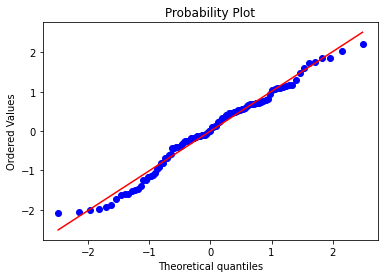

In [37]:
#Q-Q plotから正規性を判断する
st.probplot(filtered_df["Residuals"], dist = "norm", plot = plt)
plt.show()

上記の結果から、残差に正規性はあると結論付けられる。ヒストグラム単体で見ると、多少のズレは確認できるが、QQプロットからは殆どズレは感じられない。

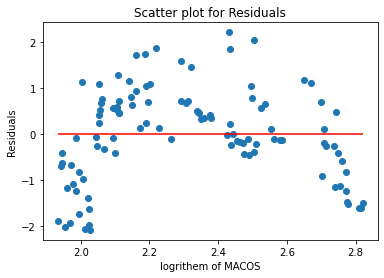

In [44]:
#残差VSlogMACの描写
plt.scatter(filtered_df["LogMac"], filtered_df["Residuals"])
plt.hlines(0, filtered_df["LogMac"].min(), filtered_df["LogMac"].max(), color = "red")
plt.title("Scatter plot for Residuals")
plt.xlabel("logrithem of MACOS")
plt.ylabel("Residuals")
plt.show()

In [51]:
#新規モデルの生成
model3 = sm.gls("WINDOWS~LogMac", filtered_df).fit()
print(model3.summary2())

               Results: Generalized least squares
Model:              GLS              Adj. R-squared:     0.764   
Dependent Variable: WINDOWS          AIC:                509.2752
Date:               2022-11-24 12:36 BIC:                514.6209
No. Observations:   107              Log-Likelihood:     -252.64 
Df Model:           1                F-statistic:        343.7   
Df Residuals:       105              Prob (F-statistic): 6.82e-35
R-squared:          0.766            Scale:              6.7073  
-----------------------------------------------------------------
               Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
-----------------------------------------------------------------
Intercept     116.6425   2.1403  54.4986 0.0000 112.3987 120.8863
LogMac        -17.0061   0.9174 -18.5381 0.0000 -18.8251 -15.1872
-----------------------------------------------------------------
Omnibus:              1.734        Durbin-Watson:           0.255
Prob(Omnibus):        0.42

In [52]:
#モデル3のWindows_hatの生成と、残差の計算
filtered_df["New_Win_pred"] = model3.predict(filtered_df)
filtered_df["New_Residuals"] = filtered_df["New_Win_pred"] - filtered_df["WINDOWS"]
filtered_df.tail(3)

,index,MacOS,WINDOWS,LogMac,Win_pred,Residuals,New_Win_pred,New_Residuals
104,114,14.44,68.38,2.670002,71.236107,1.113267,71.236107,2.856107
105,115,15.08,71.13,2.713369,70.498598,-0.246111,70.498598,-0.631402
106,116,15.01,71.06,2.708717,70.577723,-0.187984,70.577723,-0.482277


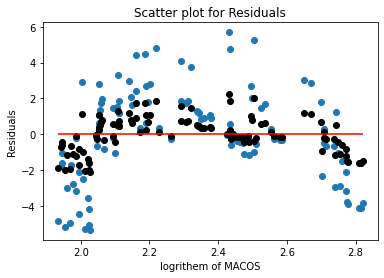

In [53]:
#残差VSlogMACの描写
plt.scatter(filtered_df["LogMac"], filtered_df["New_Residuals"])
plt.scatter(filtered_df["LogMac"], filtered_df["Residuals"], color = "black")
plt.hlines(0, filtered_df["LogMac"].min(), filtered_df["LogMac"].max(), color = "red")
plt.title("Scatter plot for Residuals")
plt.xlabel("logrithem of MACOS")
plt.ylabel("Residuals")
plt.show()

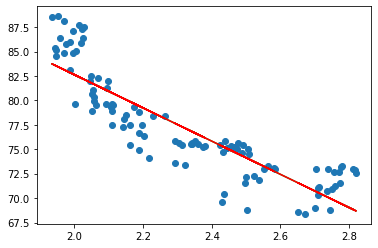

In [57]:
#回帰の確認
plt.scatter(filtered_df["LogMac"], filtered_df["WINDOWS"])
plt.plot(filtered_df["LogMac"], filtered_df["Win_pred"], color = "green")
plt.plot(filtered_df["LogMac"], filtered_df["New_Win_pred"], color = "red")
plt.show()


結論
---
MACOSとWINDOWSは逆対数関係にある事が分かった。

この事から、MACOSは登場してから一気にシェア率を伸ばしていき、WINDOWSのシェアを多く奪ってきた事が分かる。ただ、ここ数年では落ち着きを見せていて、これ以上WINDOWSのシェアを奪う可能性は低いと言える。

ただ、残差のバラツキに何らかの法則性がある事から、感知できていない変数が存在する事は明らかである。

この事から、MACOSが今後市場を独占する可能性が低いとは言え、100％ないとは言い切れない。
